In [98]:
import pandas as pd  
import numpy as np
from datetime import datetime as dt
import backtrader as bt
import tushare as ts 
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False 
import lppls
from jupyterthemes import jtplot
jtplot.style()
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
warnings.filterwarnings(action='once')
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo
%matplotlib inline 

In [77]:
import random
import math 

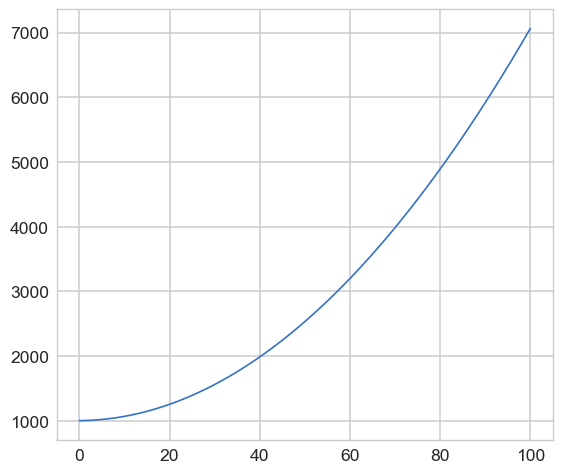

In [109]:
S0 = 1000
t = [i for i in range(0, 101)]
S = [S0]
for i in t[1:]:
    S.append(S[-1] + i*1.2)

plt.plot(t, S)

Text(0.5, 1.0, 'Brownian Motion Model Stock Price')

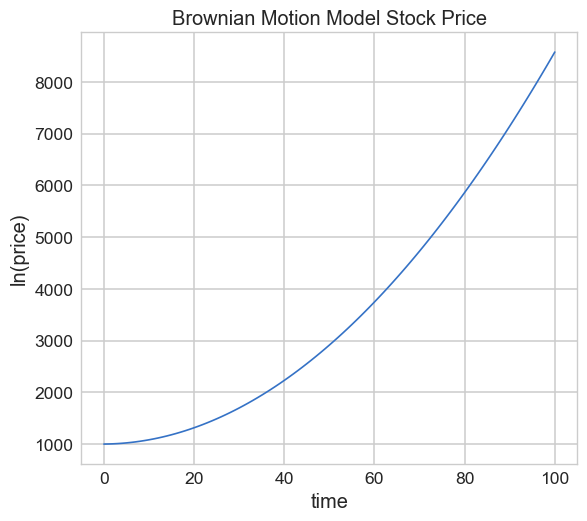

In [103]:
plt.plot(t, S)
plt.xlabel('time')
plt.ylabel('ln(price)')
plt.title('Brownian Motion Model Stock Price')

Text(0.5, 1.0, 'LPPLS and Brownian Motion Model Stock Price')

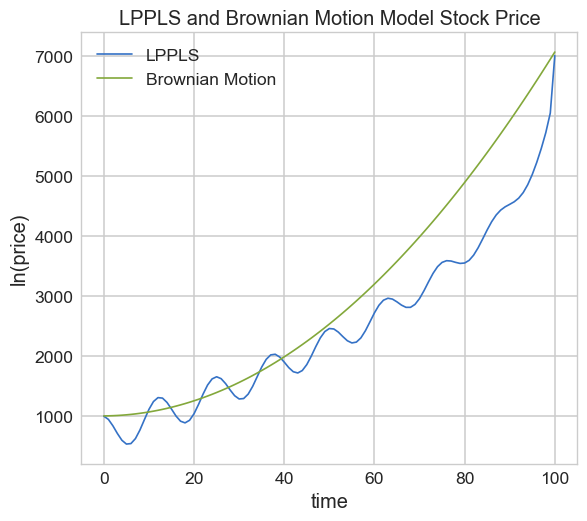

In [110]:
plt.plot(t, P)
plt.plot(t, S)
plt.xlabel('time')
plt.ylabel('ln(price)')
plt.legend(['LPPLS', 'Brownian Motion'])
plt.title('LPPLS and Brownian Motion Model Stock Price')

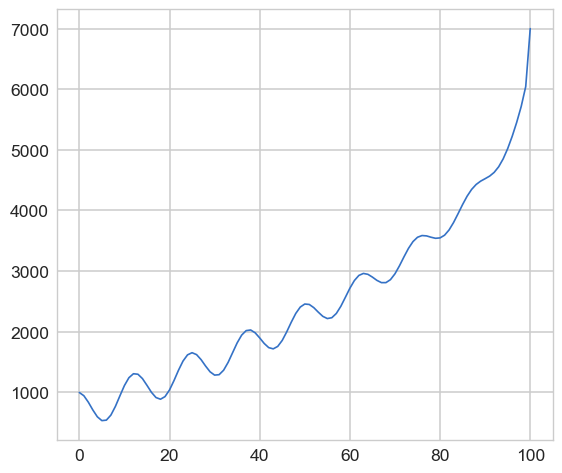

In [89]:
P = []
for i in t:
    P.append(7000 - 1000 * ((100-i)**0.4) + 50 * ((100-i)**0.4 * cos(0.5 * (100-i)) ))

plt.plot(t, P)


In [5]:
hs300stocks = pd.read_csv('hs300-members.csv')['S_CON_WINDCODE'].values
hs300stocks = [stock[:-3] for stock in hs300stocks]

In [6]:
# 2020.7.5-2023.7.5
# window size 80: 2020.3.10
def get_data(code,start='2020-01-18',end='2023-07-05'):
    df=ts.get_k_data(code,autype='qfq',start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df['time']=df.index
    df['openinterest']=0
    df=df[['time','open','high','low','close','volume','openinterest']]
    return df

In [7]:
def process_etf_data(df):
    df.date = df.apply(lambda x: dt.strptime(str(x['time']), '%Y%m%d').strftime("%Y-%m-%d %H:%M:%S"), axis=1)
    return df

In [8]:
# preprocess etf dataframe
etf_df = pd.read_csv('etf-trade-data-2020-2023.csv', encoding='gbk')
etf_lst = etf_df['FUND_CODE'].unique()
etf_df.index = etf_df['TRADE_DT']
etf_df = etf_df.rename(columns={'TRADE_DT':'time', 'S_DQ_AMOUNT':'volume', 'S_DQ_ADJOPEN':'open', 'S_DQ_ADJCLOSE':'close', 'S_DQ_ADJLOW':'low', 'S_DQ_ADJHIGH':'high'})

In [9]:
class custom_data_loader(bt.feeds.PandasData):
    lines = ("pos_conf","neg_conf",'pos','neg')
    params = (("pos_conf", 'pos_conf'),("neg_conf", 'neg_conf'), ('pos','pos'),('neg','neg'))
    datafields = bt.feeds.PandasData.datafields + (["pos_conf", "neg_conf",'pos','neg'])

In [8]:
# 30 stocks randomly selected
stocks = ['000333', '000651', '000895', '002007', '002032', '002415', '002714', '300015', '300122', '300498', '600036', '600519', '600660', '600887', '601088', 
          '601318', '601601', '601888', '603259', '603986', '000572', '600735', '600216', '600732', '600735', '600365', '600603', '600613', '000837', '002072']

In [10]:
def calc_indicator(stock, dataframe=None):
    if dataframe is None:
        dataframe=get_data(stock)
    time = [pd.Timestamp.toordinal(dt.strptime(str(t1), '%Y%m%d')) for t1 in dataframe.index]
    price = np.log(dataframe['close'].values)
    observations = np.array([time, price])

    lppls_model = lppls.LPPLS(observations=observations)
    res = lppls_model.mp_compute_nested_fits(
                workers=20,
                window_size=80,
                smallest_window_size=5,
                outer_increment=2,
                inner_increment=2,
                max_searches=25,
    )
    return dataframe, lppls_model, res
    

In [ ]:
etf_df_lst = []
for etf in etf_lst:
    etf_price = etf_df[etf_df['FUND_CODE'] == etf]
    dataframe, lppls_model, res = calc_indicator(etf, etf_price)
    etf_df_lst.append((dataframe, lppls_model, res))
np.savez('etf_df_lst.npz', etf_df_lst)

In [7]:
etf_df_lst= []
data = np.load('etf_df_lst.npz', allow_pickle=True)
arr_0 = data['arr_0']
for i in arr_0:
    etf_df_lst.append(i)

In [10]:
etf_filt_lst = []
for etf_ind in range(len(etf_lst)):
    temp_data = filt(etf_df_lst[etf_ind][0], etf_df_lst[etf_ind][1], etf_df_lst[etf_ind][1].indicator_result)
    temp_data.index = temp_data['date']
    etf_filt_lst.append(temp_data)

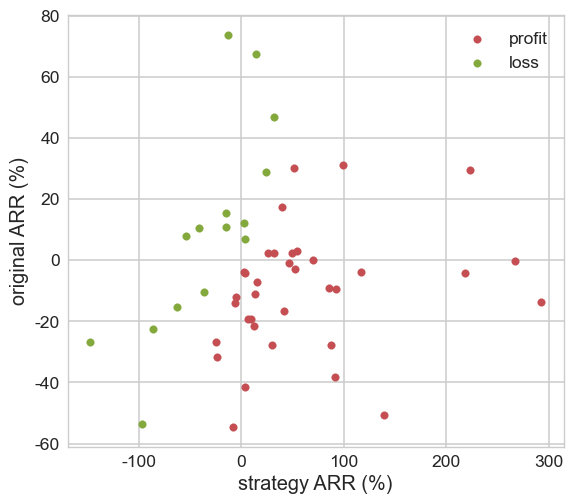

In [243]:
%matplotlib inline 
plt.scatter(profit['strategy ARR (%)'], profit['original ARR (%)'], color = 'r', label='profit')
plt.scatter(loss['strategy ARR (%)'], loss['original ARR (%)'], color = 'g', label='loss')
plt.xlabel('strategy ARR (%)')
plt.ylabel('original ARR (%)')

plt.legend()
plt.show()


In [2]:
2770903.96-3000000

-229096.04000000004

In [ ]:
res_lst = []
for df_ind in range(len(etf_filt_lst)):
    dataframe = etf_filt_lst[df_ind]
    if dataframe['pos_conf'].sum() > 0 and dataframe['neg_conf'].sum() > 0 and len(dataframe) > 120:
        etf_code = etf_lst[df_ind]
        res_lst.append((*backtrade(dataframe), round(3000000/2*(dataframe['close'][-1]/dataframe['close'][20]), 2), 
                        round((dataframe['close'][-1]/dataframe['close'][20]-1)/((len(dataframe)-20)/5*7/365)*100, 2), etf_code))
        figure = res_lst[-1][0].plot(style='line', volume=False, broker=False)[0][0]
        figure.savefig('figures/etf'+ etf_code + '.png', dpi=500)
        figure.clear(True)

print(np.mean([x[1] for x in res_lst]), np.mean([x[-3] for x in res_lst]), np.mean([x[5] for x in res_lst]))


In [11]:
def filt(dataframe, lppls_model, res, filter_conditions_config = None):
    res_df = lppls_model.compute_indicators(res, filter_conditions_config)
    res_df['time'] = [pd.Timestamp(pd.Timestamp.fromordinal(int(t1)).strftime('%Y-%m-%d %H:%M:%S')) for t1 in res_df['time']]

    dataframe['time'] = pd.to_datetime(dataframe['time'], format='%Y%m%d')
    
    dataframe=dataframe.merge(res_df, on='time')
    dataframe = dataframe.rename(columns={'time':'date'})
    '''# test
    dataframe = dataframe.merge(newtvdf, on='date')
    dataframe = dataframe.rename(columns={'TURNOVER_RATE':'turnover'})'''
    return dataframe

In [13]:
class LPPLSStrategy(bt.Strategy):
    def __init__(self):
        #指定价格序列
        self.dataclose=self.datas[0].close
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.ordered = False
        self.freq = 10
        self.buy_days = 1
        self.sell_days = 1

    def next(self):
        if not self.ordered:  # If no position is currently held, place the initial buy order
            self.size = 3000000/2/self.data.close[0]
            self.buy(size=self.size, price=self.data.close[0])
            self.ordered = True

        cash = self.broker.getcash()
        value = self.broker.getvalue()
        # if self.trade_days > self.freq:
        if self.datas[0].neg_conf[0] > 0:
            buy_size =  cash/4/self.datas[0].close[0]
            self.order = self.buy(size=buy_size)
            # self.log(f"""买入成交量{buy_size}""")
            '''self.buy_days = 2
            self.sell_days = 1'''
        elif self.datas[0].pos_conf[0] > 0:
            sell_size = (value-cash)/4/self.datas[0].close[0]
            self.order = self.sell(size=sell_size)
            # self.log(f"""卖出成交量{sell_size}""")
            '''self.sell_days = 2
            self.buy_days = 1'''
        '''if self.buy_days > 1:
            self.buy_days += 1
        if self.sell_days > 1:
            self.sell_days += 1'''

    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))



In [14]:
class ATRStopLoss(bt.Strategy):
    def __init__(self):
        #指定价格序列
        self.dataclose=self.datas[0].close
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.ordered = False

        self.ATR = bt.indicators.ATR(self.data, period=20)   
        self.buy_price = 0  
        self.buy_times = 0

        self.freq = 10
        self.buy_days = 1
        self.sell_days = 1

        self.borrow = 0


    def next(self):
        cash = self.broker.getcash()
        value = self.broker.getvalue()
        if not self.ordered:  # If no position is currently held, place the initial buy order
            self.size = cash/2/self.data.close[1]
            self.buy(size=self.size)
            self.buy_price = self.data.close[1]
            self.buy_times += 1
            self.ordered = True
            pass
        
        if  self.datas[0].neg_conf[0] > 0:
            if self.buy_times == 0 or (self.datas[0].close[0] > self.buy_price+0.5*self.ATR[0] and self.buy_times < 5):
                buy_size = 10000000 * self.datas[0].neg_conf[0] * 1.5
                # buy_size =  cash*self.datas[0].neg_conf[0]/self.datas[0].close[0]
                borrow = (buy_size*self.datas[0].close[0] - cash + 1500000)*1.5
                if borrow > 0:
                    self.broker.add_cash(borrow)
                    self.borrow += borrow
                self.order = self.buy(size=buy_size/1.5)
                self.buy_price = self.datas[0].close[0]
                self.buy_times += 1
            elif self.datas[0].close[0] < (self.buy_price - 2*self.ATR[0]):           
                self.order = self.close()
                self.buy_times = 0
        elif self.datas[0].pos_conf[0] > 0:
            # sell_size = (value-cash)*self.datas[0].pos_conf[0]/self.datas[0].close[0]
            sell_size = min(10000000 * self.datas[0].pos_conf[0], self.getposition().size)
            self.order = self.sell(size=sell_size)
            self.buy_times = 0
            # self.log(f"""卖出成交量{sell_size}""")


    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))



In [15]:
class ATRStopLoss_origin(bt.Strategy):
    def __init__(self):
        #指定价格序列
        self.dataclose=self.datas[0].close
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.ordered = False

        self.ATR = bt.indicators.ATR(self.data, period=20)   
        self.buy_price = 0  
        self.buy_times = 0

        self.freq = 10
        self.buy_days = 1
        self.sell_days = 1

        self.borrow = 0
        self.close_price = 0


    def next(self):
        cash = self.broker.getcash()
        value = self.broker.getvalue()
        if not self.ordered:  # If no position is currently held, place the initial buy order
            self.size = cash/2/self.data.close[1]
            self.buy(size=self.size)
            self.buy_price = self.data.close[1]
            self.buy_times += 1
            self.ordered = True
            pass

        if self.datas[0].neg_conf[0] > 0:
            # self.datas[0].close[0] > self.buy_price+0.5*self.ATR[0] and
            if (self.close_price == 0 and self.buy_times < 5 and abs(self.datas[0].close[0] - self.buy_price) >= 0.5 * self.ATR[0]) or (self.close_price > 0 and self.datas[0].close[0] < (self.close_price - 2*self.ATR[0])):
                buy_size = cash/4/self.datas[0].close[0]
                self.order = self.buy(size=buy_size)
                self.buy_price = self.datas[0].close[0]
                self.buy_times += 1
                
            elif self.datas[0].close[0] < (self.buy_price - 2*self.ATR[0]):
                self.order = self.close()
                self.buy_times = 0
                self.close_price = self.datas[0].close[0]
        elif self.datas[0].pos_conf[0] > 0:
            sell_size = (value-cash)/4/self.datas[0].close[0]
            self.order = self.sell(size=sell_size)
            self.buy_times = 0
            self.close_price = 0

    def log(self, txt, dt=None):
        '''输出日志'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

In [20]:
def backtrade(dataframe):
    dataframe.index = dataframe['date']
    # backtrade period
    start=dt(2020, 1, 1)
    end=dt(2023, 7, 30)
    # initialize cerebro                         
    cerebro = bt.Cerebro()  
    # load data
    data = custom_data_loader(dataname=dataframe,fromdate=start,todate=end)
    cerebro.adddata(data) 
    # add analyzer
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.003, annualize=True, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')


    # add observer
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addobserver(bt.observers.TimeReturn)
    # load strategy
    cerebro.addstrategy(ATRStopLoss_origin) 
    # cerebro.addstrategy(LPPLSStrategy) 
    # start cash: 100000
    startcash = 3000000
    cerebro.broker.setcash(startcash)
    cerebro.broker.set_coc(True)
     
    # transaction fee: 0.3%
    cerebro.broker.setcommission(commission=0.003) 
    d1=start.strftime('%Y%m%d')
    d2=end.strftime('%Y%m%d')
    print(f'初始资金: {startcash}\n回测期间: {d1}:{d2}')
    # run cerebro
    strats = cerebro.run(tradehistory=True)
    strat = strats[0]
    # get end value
    # portvalue = round(cerebro.broker.getvalue()-strat.borrow-startcash/2, 2)
    portvalue = round(cerebro.broker.getvalue())
    # get net profit
    # pnl = round(portvalue - startcash/2, 2)
    # yield_rate = round(pnl/(startcash/2)/((len(dataframe)-20)/5*7/365)*100, 2)
    pnl = round(portvalue - startcash)
    yield_rate = round(pnl/startcash/((len(dataframe)-20)/5*7/365)*100, 2)

    print(f'总资金: {portvalue}')
    print(f'净收益: {pnl}')
    print(f'年化收益率： {yield_rate}%')

    sharperatio = strat.analyzers.SharpeRatio.get_analysis()['sharperatio']
    max_drawdown = strat.analyzers.DrawDown.get_analysis()['max']['drawdown']

    
    print('AnnualReturn:', strat.analyzers.AnnualReturn.get_analysis())
    print('SharpeRatio:', sharperatio)
    print('Max DrawDown:', max_drawdown)
    return cerebro, portvalue, sharperatio, max_drawdown, pnl, yield_rate, strat

In [275]:
# 正常资产波动：线性增长项+布朗运动项
# 泡沫资产：指数增长项+周期波动项


# 和原市场图对比，比如沪深300的图

# 562500
# 159766换style
# 把净值曲线，value，cash图放一起对比

In [318]:
dataframe, lppls_model, res = calc_indicator('562500')
dataframe = filt(dataframe, lppls_model, res)
res = backtrade(dataframe)
res[0].plot(style='line', volume=False)[0][0]

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


C:\Users\zhanq\AppData\Roaming\Python\Python39\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
C:\Users\zhanq\AppData\Roaming\Python\Python39\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
  0%|          | 0/144 [00:00<?, ?it/s]

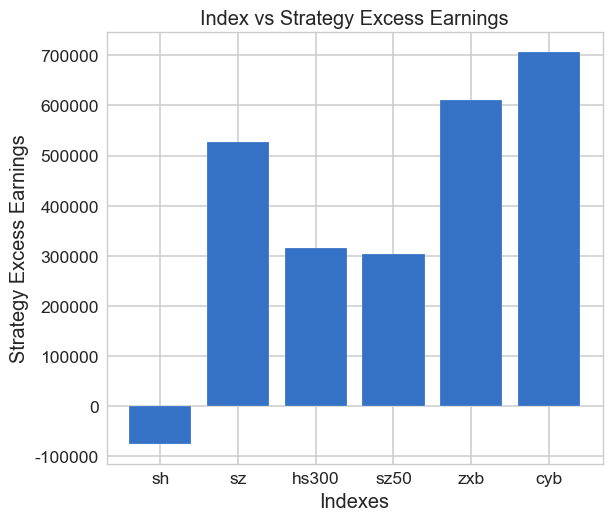

In [259]:
%matplotlib inline 
plt.bar(indexs, res_lst)
plt.title("Index vs Strategy Excess Earnings")
plt.xlabel("Indexes")
plt.ylabel("Strategy Excess Earnings")
plt.show()


In [ ]:
res_lst = []
for dataframe in index_lst:
    res_lst.append((*backtrade(dataframe), 3000000*(dataframe['close'][-1]/dataframe['close'][0])))
print(np.mean([x[1] for x in res_lst]), np.mean([x[-1] for x in res_lst]), [x[1]-x[-1] for x in res_lst])
res_lst[0][0].plot()[0][0]

In [83]:
index_lst = []
for stock_ind in range(len(indexs)):
    temp_data = filt(data_lst[stock_ind][0], data_lst[stock_ind][1], data_lst[stock_ind][1].indicator_result)
    index_lst.append(temp_data)

In [12]:
class RankStrategy(bt.Strategy):
    def __init__(self):
        '''#指定价格序列
        self.dataclose=self.datas[0].close'''
        # 初始化交易指令、买卖价格和手续费
        self.order = {}
        for i, d in enumerate(d for d in self.datas if len(d)):
            self.order[d._name] = None
        self.buyprice = None
        self.buycomm = None
        self.ordered = False
        self.ordered = False

    def next(self):
        if not self.ordered:  # If no position is currently held, place the initial buy order
            for data in self.datas:
                self.buy(data=data, size=5000/data.close[0])
            self.ordered = True
            self.log(f"""现账户总值{self.broker.getvalue()}""")

        self.log(f"""现账户总值{self.broker.getvalue()}""")
        neg_conf_lst = []
        pos_conf_lst = []
        for data in self.datas:
            if data.neg_conf[0] > 0:
                neg_conf_lst.append([data._name, data.neg_conf])
            if data.pos_conf[0] > 0:
                pos_conf_lst.append([data._name, data.pos_conf])

        sorted_pos_conf = sorted(pos_conf_lst, key=lambda x:x[1],reverse=True)
        sell_lst = [i[0] for i in sorted_pos_conf[:5]]
        sorted_neg_conf = sorted(neg_conf_lst, key=lambda x:x[1],reverse=True)
        buy_lst = [i[0] for i in sorted_neg_conf[:5]]
        print(sell_lst, buy_lst)

        for data in self.datas:
            if data._name in buy_lst:
                buy_size = 10000*(0.5+data.neg[0])*data.neg_conf[0]/data.close[0]
                self.order = self.buy(data=data, size=buy_size)
                self.log(f"""买入{data._name}, 成交量{buy_size}""")
        cash = self.broker.getcash()
        value = self.broker.getvalue()   
        for data in self.datas:
            if data._name in sell_lst:
                sell_size = 10000*data.pos_conf[0]/data.close[0]*(0.5+data.pos[0])*5
                self.order = self.sell(data=data, size=sell_size)
                self.log(f"""卖出{data._name}, 成交量{sell_size}""")
            
        # self.log(f"""现账户总值{self.broker.getvalue()}""")

               

    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
       
    '''
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None
    '''



In [16]:
class RLHS20days(bt.Strategy):
    def __init__(self):
        '''#指定价格序列
        self.dataclose=self.datas[0].close'''
        # 初始化交易指令、买卖价格和手续费
        self.order = {}
        for i, d in enumerate(d for d in self.datas if len(d)):
            self.order[d._name] = None
        self.buyprice = None
        self.buycomm = None
        self.hold_days_limit = 20

        self.startcash = self.broker.getcash()
        self.leverage = 1
        self.hold_days = {data: 0 for data in self.datas}


    def next(self):
        '''if self.ordered is False:  # If no position is currently held, place the initial buy order
            for data in self.datas:
                self.order = self.buy(data=data, size=10000/data.close[0])
            self.ordered = True'''
        
            
        self.log(f"""现账户总值{self.broker.getvalue()}""")
        neg_conf_lst = []
        pos_conf_lst = []
        for data in self.datas:
            if data.neg_conf[0] > 0:
                neg_conf_lst.append([data._name, data.neg_conf])
            if data.pos_conf[0] > 0:
                pos_conf_lst.append([data._name, data.pos_conf])

        sorted_pos_conf = sorted(pos_conf_lst, key=lambda x:x[1],reverse=True)[:10]
        sorted_neg_conf = sorted(neg_conf_lst, key=lambda x:x[1],reverse=True)[:10]
        pos_conf_sum = sum([i[1] for i in sorted_pos_conf])
        neg_conf_sum = sum([i[1] for i in sorted_neg_conf])
        sell_lst = [i[0] for i in sorted_pos_conf]
        buy_lst = [i[0] for i in sorted_neg_conf]
        
       

        for data in self.datas:
            if data._name in sell_lst:
                sell_size = self.startcash*self.leverage/self.hold_days_limit/data.close[0]*data.pos_conf/pos_conf_sum
                self.order = self.sell(data=data, size=sell_size)
                self.log(f"""卖出{data._name}, 成交量{sell_size}""")
        for data in self.datas:
            if data._name in buy_lst:
                buy_size = self.startcash*self.leverage/self.hold_days_limit/data.close[0]*data.neg_conf/neg_conf_sum
                self.order = self.buy(data=data, size=buy_size)
                self.log(f"""买入{data._name}, 成交量{buy_size}""")
        for data in self.datas:
            if data._name not in sell_lst and data._name not in buy_lst:
                if self.getposition(data).size != 0:
                    self.hold_days[data] += 1   
            if self.hold_days[data] > self.hold_days_limit:
                self.close(data)
                self.hold_days[data] = 0


    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    '''def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        # , order.Rejected, order.Margin
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"""买入{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            elif order.issell():
                self.log(f"""卖出{order.data._name}, 成交量{order.executed.size}，成交价{order.executed.price:.2f}""")
            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None'''



In [17]:
def backtrade_multiple(dt_lst, stocks):
    # dataframe.index = dataframe['date']
    # backtrade period
    start=dt(2022, 7, 5)
    end=dt(2023, 7, 5)
    # initialize cerebro                         
    cerebro = bt.Cerebro()  
    # load data
    for dt_item, stock in zip(dt_lst, stocks):
        data = custom_data_loader(dataname=dt_item, fromdate=start, todate=end, plot=False)
        data._name = stock  # Set the name for the data feed (stock name)
        cerebro.adddata(data)
    # add analyzer
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.003, annualize=True, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
    # add observer
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addobserver(bt.observers.TimeReturn)
    # load strategy
    cerebro.addstrategy(RLHS20days) 
    # start cash: 100000
    startcash = 3000000
    cerebro.broker.setcash(startcash)

    # cerebro.broker.set_coc(True)
    
    # transaction fee: 0.3%
    cerebro.broker.setcommission(commission=0.003) 
    d1=start.strftime('%Y%m%d')
    d2=end.strftime('%Y%m%d')
    print(f'初始资金: {startcash}\n回测期间: {d1}:{d2}')
    # run cerebro
    strats = cerebro.run()
    strat = strats[0]
    # get end value
    portvalue = round(cerebro.broker.getvalue(), 2)
    # get net profit
    pnl = round(portvalue - startcash, 2)

    print(f'总资金: {portvalue}')
    print(f'净收益: {pnl}')

    sharperatio = round(strat.analyzers.SharpeRatio.get_analysis()['sharperatio'], 2)
    max_drawdown = round(strat.analyzers.DrawDown.get_analysis()['max']['drawdown'], 2)
    
    print('AnnualReturn:', strat.analyzers.AnnualReturn.get_analysis())
    print('SharpeRatio:', sharperatio)
    print('Max DrawDown:', max_drawdown)
    return cerebro, portvalue, sharperatio, max_drawdown, pnl

初始资金: 3000000
回测期间: 20220705:20230705
2022-07-20, 现账户总值3000000.0
2022-07-20, 卖出000568, 成交量48.890052328739024
2022-07-20, 卖出000625, 成交量782.161666131056
2022-07-20, 卖出600754, 成交量144.11129167427427
2022-07-20, 卖出600438, 成交量262.72602447495836
2022-07-20, 卖出300751, 成交量58.78038768167056
2022-07-20, 卖出603185, 成交量96.30334445908213
2022-07-20, 卖出600674, 成交量1682.3525084482678
2022-07-20, 卖出601615, 成交量455.85173614156565
2022-07-20, 卖出601689, 成交量285.4045582128114
2022-07-20, 卖出605117, 成交量65.82119127278449
2022-07-20, 买入601601, 成交量601.1341506591465
2022-07-20, 买入600018, 成交量1721.2339206411777
2022-07-20, 买入600436, 成交量28.279908229601503
2022-07-20, 买入600346, 成交量550.9346456754936
2022-07-20, 买入002841, 成交量189.62856195347248
2022-07-20, 买入688036, 成交量337.49955544660406
2022-07-20, 买入601865, 成交量567.3083609217281
2022-07-20, 买入002648, 成交量448.6000787608849
2022-07-20, 买入300979, 成交量443.6534899880504
2022-07-20, 买入000733, 成交量106.04482797094666
2022-07-20, 现账户总值3000000.0
2022-07-20, 卖出000568, 成交量48.89005232873

<IPython.core.display.Javascript object>

C:\Users\zhanq\AppData\Roaming\Python\Python39\site-packages\backtrader\plot\locator.py:228: MatplotlibDeprecationWarning: 
The set_view_interval function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use `.Axis.set_view_interval` instead.
  locator.set_view_interval(*self.axis.get_view_interval())
C:\Users\zhanq\AppData\Roaming\Python\Python39\site-packages\backtrader\plot\locator.py:229: MatplotlibDeprecationWarning: 
The set_data_interval function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use `.Axis.set_data_interval` instead.
  locator.set_data_interval(*self.axis.get_data_interval())


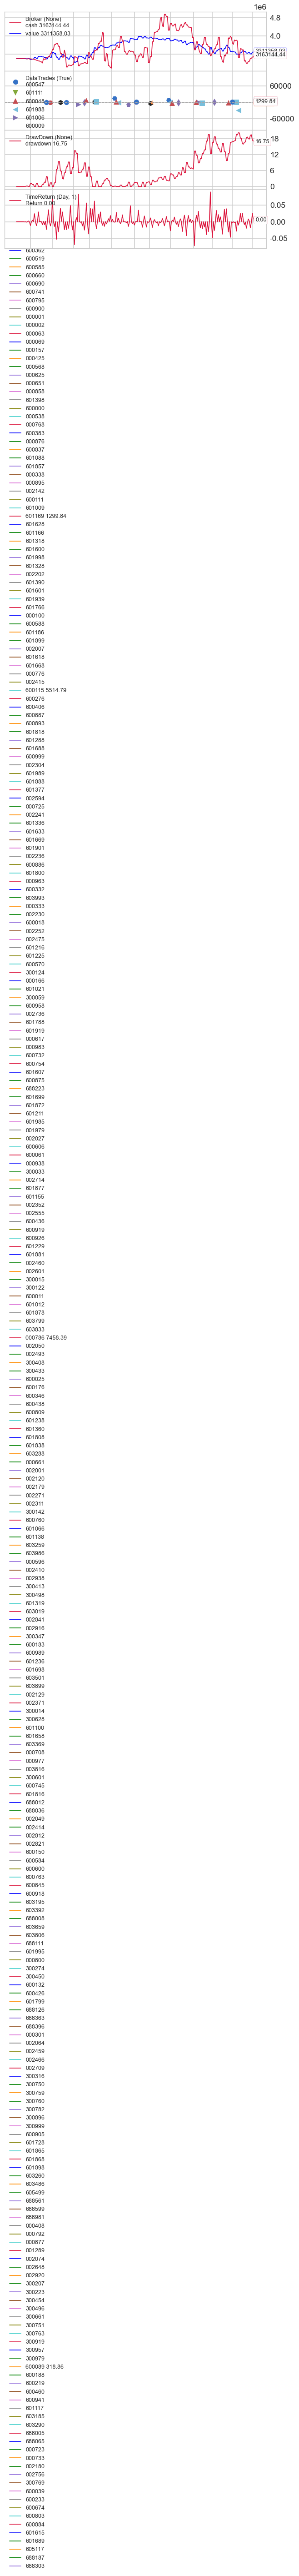

In [18]:
res_lst = backtrade_multiple(hs300data_lst, hs300stocks)
'''b = Bokeh(style='bar', scheme=Tradimo())
res_lst[0].plot(b)'''
res_lst[0].plot(stdstats=False, style='candle', volume=False,usebracket=False)[0][0]

#### 指数增强

In [254]:
res_lst = []

In [255]:
for index in dt_lst:
    dataframe, lppls_model, res = index
    dataframe = filt(dataframe, lppls_model, res)
    res = backtrade(dataframe)
    res_lst.append(res[1] - 3000000*dataframe['close'][-1]/dataframe['close'][20])

    

初始资金: 3000000
回测期间: 20200101:20230730
总资金: 2878392
净收益: -121608
年化收益率： -3.12%
AnnualReturn: OrderedDict([(2020, 0.019964829050490573), (2021, 0.0320268822886125), (2022, -0.11100481954324648), (2023, 0.02530509857430041)])
SharpeRatio: -0.19244717886339044
Max DrawDown: 15.071870113608988
初始资金: 3000000
回测期间: 20200101:20230730
总资金: 3068557
净收益: 68557
年化收益率： 1.76%
AnnualReturn: OrderedDict([(2020, 0.03913425850871177), (2021, 0.08673189507296986), (2022, -0.09056155243254471), (2023, -0.004031760663392059)])
SharpeRatio: 0.0738492087462762
Max DrawDown: 19.646462431719215
初始资金: 3000000
回测期间: 20200101:20230730
总资金: 2810274
净收益: -189726
年化收益率： -4.86%
AnnualReturn: OrderedDict([(2020, 0.03620231460836987), (2021, 0.005950803529122917), (2022, -0.1098510368826936), (2023, 0.009586105046790028)])
SharpeRatio: -0.3115506160966131
Max DrawDown: 14.812166007950594
初始资金: 3000000
回测期间: 20200101:20230730
总资金: 2597265
净收益: -402735
年化收益率： -10.32%
AnnualReturn: OrderedDict([(2020, 0.03775811485929759)

In [10]:
data_lst = []
data = np.load('index120.npz', allow_pickle=True)
arr_0 = data['arr_0']
for i in arr_0:
    data_lst.append(i)

In [ ]:
indexs = ['sh', 'sz', 'hs300', 'sz50', 'zxb', 'cyb']
process_lst = []
for index in indexs:
    dataframe, lppls_model, res = calc_indicator(index)
    process_lst.append((dataframe, lppls_model, res))

In [118]:
np.savez('index120.npz', process_lst)

C:\Users\zhanq\AppData\Roaming\Python\Python39\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


#### 沪深300对冲

In [ ]:
res_lst = backtrade_multiple(hs300data_lst, hs300stocks)
'''b = Bokeh(style='bar', scheme=Tradimo())
res_lst[0].plot(b)'''
res_lst[0].plot(stdstats=False, style='candle', volume=False,usebracket=False)[0][0]

#### 数据导入

In [13]:
dt_lst= []
data = np.load('dt_lst.npz', allow_pickle=True)
arr_0 = data['arr_0']
for i in arr_0:
    dt_lst.append(i)

In [14]:
hs300data_lst = []
for stock_ind in range(len(hs300stocks)):
    temp_data = filt(dt_lst[stock_ind][0], dt_lst[stock_ind][1], dt_lst[stock_ind][1].indicator_result)
    temp_data.index = temp_data['date']
    hs300data_lst.append(temp_data)

In [23]:
lst = [(hs300stocks[i], hs300data_lst[i].tail(1)['pos_conf'].item()) for i in range(len(hs300stocks))]

In [25]:
hs300data_lst[0]

,date,open,high,low,close,volume,openinterest,price,pos_conf,neg_conf,pos,neg,_fits
date,,,,,,,,,,,,,
2022-07-12,2022-07-12,17.62,17.63,17.50,17.61,142983.0,0,2.868467,0.0,0.0,0.216216,0.783784,"[{'tc_d': 'NaT', 'tc': 0, 'm': 0, 'w': 0, 'a':..."
2022-07-14,2022-07-14,17.64,17.72,17.53,17.66,135607.0,0,2.871302,0.0,0.0,0.351351,0.648649,"[{'tc_d': 'NaT', 'tc': 0, 'm': 0, 'w': 0, 'a':..."
2022-07-18,2022-07-18,17.40,17.70,17.39,17.68,171203.0,0,2.872434,0.0,0.0,0.289474,0.710526,"[{'tc_d': '2022-08-02', 'tc': 738369.839588642..."
2022-07-20,2022-07-20,17.68,17.78,17.65,17.71,133238.0,0,2.874129,0.0,0.0,0.421053,0.578947,"[{'tc_d': '2022-08-16', 'tc': 738383.509827116..."
2022-07-22,2022-07-22,17.78,17.87,17.54,17.67,144025.0,0,2.871868,0.0,0.0,0.236842,0.763158,"[{'tc_d': '2022-07-31', 'tc': 738367.389788661..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-21,2023-06-21,23.43,23.81,23.24,23.28,158650.0,0,3.147595,0.0,0.0,0.218750,0.781250,"[{'tc_d': 'NaT', 'tc': 0, 'm': 0, 'w': 0, 'a':..."
2023-06-27,2023-06-27,23.11,23.76,23.11,23.70,158808.0,0,3.165475,0.0,0.0,0.363636,0.636364,"[{'tc_d': 'NaT', 'tc': 0, 'm': 0, 'w': 0, 'a':..."
2023-06-29,2023-06-29,23.49,23.98,23.10,23.81,175262.0,0,3.170106,0.0,0.0,0.323529,0.676471,"[{'tc_d': 'NaT', 'tc': 0, 'm': 0, 'w': 0, 'a':..."


In [24]:
sorted(lst, key=lambda x:x[1],reverse=True)

[('002475', 0.3333333333333333),
 ('000063', 0.16666666666666666),
 ('600845', 0.15789473684210525),
 ('600732', 0.11538461538461539),
 ('000625', 0.1111111111111111),
 ('600760', 0.1111111111111111),
 ('601689', 0.1111111111111111),
 ('601799', 0.1),
 ('001289', 0.08333333333333333),
 ('601808', 0.07692307692307693),
 ('002241', 0.0625),
 ('600188', 0.05555555555555555),
 ('601138', 0.05),
 ('603486', 0.041666666666666664),
 ('002920', 0.041666666666666664),
 ('300496', 0.04),
 ('605499', 0.034482758620689655),
 ('600875', 0.030303030303030304),
 ('600547', 0.0),
 ('601111', 0.0),
 ('600048', 0.0),
 ('601988', 0.0),
 ('601006', 0.0),
 ('600009', 0.0),
 ('600010', 0.0),
 ('600015', 0.0),
 ('600016', 0.0),
 ('600019', 0.0),
 ('600028', 0.0),
 ('600029', 0.0),
 ('600030', 0.0),
 ('600031', 0.0),
 ('600036', 0.0),
 ('600050', 0.0),
 ('600085', 0.0),
 ('600104', 0.0),
 ('600196', 0.0),
 ('600309', 0.0),
 ('600362', 0.0),
 ('600519', 0.0),
 ('600585', 0.0),
 ('600660', 0.0),
 ('600690', 0.0

In [21]:
lst.sort(key=)

['600547',
 '601111',
 '600048',
 '601988',
 '601006',
 '600009',
 '600010',
 '600015',
 '600016',
 '600019',
 '600028',
 '600029',
 '600030',
 '600031',
 '600036',
 '600050',
 '600085',
 '600104',
 '600196',
 '600309',
 '600362',
 '600519',
 '600585',
 '600660',
 '600690',
 '600741',
 '600795',
 '600900',
 '000001',
 '000002',
 '000063',
 '000069',
 '000157',
 '000425',
 '000568',
 '000625',
 '000651',
 '000858',
 '601398',
 '600000',
 '000538',
 '000768',
 '600383',
 '000876',
 '600837',
 '601088',
 '601857',
 '000338',
 '000895',
 '002142',
 '600111',
 '601009',
 '601169',
 '601628',
 '601166',
 '601318',
 '601600',
 '601998',
 '601328',
 '002202',
 '601390',
 '601601',
 '601939',
 '601766',
 '000100',
 '600588',
 '601186',
 '601899',
 '002007',
 '601618',
 '601668',
 '000776',
 '002415',
 '600115',
 '600276',
 '600406',
 '600887',
 '600893',
 '601818',
 '601288',
 '601688',
 '600999',
 '002304',
 '601989',
 '601888',
 '601377',
 '002594',
 '000725',
 '002241',
 '601336',
 '601633',

#### 数据存储

In [ ]:
dt_lst = []
for stock in hs300stocks:
    print(stock)
    dataframe, lppls_model, res = calc_indicator(stock)
    dt_lst.append((dataframe, lppls_model, res))


In [32]:
np.savez('dt_lst.npz', dt_lst)

C:\Users\zhanq\AppData\Roaming\Python\Python39\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [ ]:
filter_conditions_config = ((0, 2), (1.5, 17), 2.2, 0.3)

In [23]:
def val_indicator_ratio_pro(dataframe, indicator='pos_conf'):
    # Count variables
    indicator_ratio = []
    # Iterate over dataframe rows
    for index, row in dataframe.iterrows():
        if row[indicator] != 0:
            # Check if there is a drop in price within the next five days
            if indicator == 'pos_conf':
                try:
                    low = min(dataframe.loc[index + 1: min(index + 6, len(dataframe)), 'price']) 
                except ValueError:
                    continue
                if low < row['price']:
                    indicator_ratio.append(abs(low-row['price'])/row[indicator])
                else:
                    indicator_ratio.append(0)
            if indicator == 'neg_conf':
                try:
                    high = max(dataframe.loc[index + 1: min(index + 6, len(dataframe)), 'price']) 
                except ValueError:
                    continue
                if high > row['price']:
                    indicator_ratio.append(abs(high-row['price'])/row[indicator])
                else:
                    indicator_ratio.append(0)
    # Calculate the ratio
    return round(np.std(indicator_ratio), 2)

In [24]:
def val_indicator_ratio(dataframe, indicator='pos_conf'):
    # Count variables
    total_count = 0
    val_count = 0
    # Iterate over dataframe rows
    for index, row in dataframe.iterrows():
        if row[indicator] != 0:
            # Check if there is a drop in price within the next five days
            for i in range(index + 1, min(index + 6, len(dataframe))):
                if indicator == 'pos_conf':
                    if dataframe.loc[i, 'price'] < row['price']:
                        val_count += 1
                        break
                elif indicator == 'neg_conf':
                    if dataframe.loc[i, 'price'] > row['price']:
                        val_count += 1
                        break
            total_count += 1
    # Calculate the ratio
    if total_count == 0:
        return 0
    ratio = val_count / total_count
    return round(ratio, 2)


In [27]:
vol_lst = []
sell_count_lst = []
buy_count_lst = []
pos_val_ratio_lst = []
neg_val_ratio_lst = []
sharperatio_lst = []
max_drawdown_lst = []
pnl_lst = []
change_start_lst = []
max_min_lst = []

In [ ]:
for stock_ind in range(len(stocks)):
    print(stocks[stock_ind])
    processed_dt = filt(dt_lst[stock_ind], model_lst[stock_ind], model_lst[stock_ind].indicator_result, filter_conditions_config = ((0, 2), (1.5, 17), 2.2, 0.3))
    res_lst = backtrade(processed_dt)
    
    vol_lst.append(np.std(processed_dt['close']))
    '''pos_val_ratio_lst.append(val_indicator_ratio(processed_dt, 'pos_conf'))
    neg_val_ratio_lst.append(val_indicator_ratio(processed_dt, 'neg_conf'))'''
    res_lst = backtrade(processed_dt)
    sharperatio_lst.append(res_lst[-3])
    max_drawdown_lst.append(res_lst[-2])
    pnl_lst.append(res_lst[-1])
    buy_count_lst.append(len(processed_dt[processed_dt['neg_conf']>0]))
    sell_count_lst.append(len(processed_dt[processed_dt['pos_conf']>0]))
    df = processed_dt['close']
    change_start_lst.append((max(df)-min(df))/df[0])
    max_min_lst.append((max(df)-min(df))/np.mean(df))
    figure = res_lst[0].plot(style='candlestick')[0][0]
    figure.savefig('figures/'+ stock + '.png', dpi=500)

In [ ]:
for stock in stocks:
    print(stock)
    dataframe = calc_indicator(stock)
    try:
        if dataframe['pos_conf'][0] > 0:
            pos_conf.append((stock, dataframe['pos_conf'][0]))
        if dataframe['neg_conf'][0] > 0:
            pos_conf.append((stock, dataframe['neg_conf'][0]))
        total_length += 1
    except (IndexError, AttributeError): 
        continue

In [415]:
stocks = pd.read_csv('stocks.csv')['ts_code']

In [ ]:
for stock in stocks:
    print(stock)
    stock = stock[:6]
    dataframe = calc_indicator(stock)
    try:
        if dataframe['pos_conf'][0] > 0:
            pos_conf.append((stock, dataframe['pos_conf'][0]))
        if dataframe['neg_conf'][0] > 0:
            pos_conf.append((stock, dataframe['neg_conf'][0]))
        total_length += 1
    except (IndexError, AttributeError): 
        continue

In [ ]:
for stock in stocks[8:]:
    print(stock)
    dataframe = calc_indicator(stock)
    vol_lst.append(np.std(dataframe['close']))
    sell_count.append(len(dataframe[dataframe['pos_conf'] > 0]))
    buy_count.append(len(dataframe[dataframe['neg_conf'] > 0]))
    pos_val_ratio_lst.append(val_indicator_ratio_pro(dataframe, 'pos_conf'))
    neg_val_ratio_lst.append(val_indicator_ratio_pro(dataframe, 'neg_conf'))
    res_lst = backtrade(dataframe)
    sharperatio_lst.append(res_lst[-3])
    max_drawdown_lst.append(res_lst[-2])
    pnl_lst.append(res_lst[-1])
    buy_count_lst.append(len(dataframe[dataframe['neg_conf']>0]))
    sell_count_lst.append(len(dataframe[dataframe['pos_conf']>0]))
    df = dataframe['close']
    change_start_lst.append((max(df)-min(df))/df[0])
    max_min_lst.append((max(df)-min(df))/np.mean(df))
    figure = res_lst[0].plot(style='candlestick')[0][0]
    figure.savefig('figures/'+ stock + '.png', dpi=500)

    # 22m27s+58m25.3s

In [ ]:
pnl_lst = []
pos_val_ratio_lst = []
neg_val_ratio_lst = []
sharperatio_lst = []
max_drawdown_lst = []
buy_count = []
sell_count = []
vol_lst = []
buy_count_lst = []
sell_count_lst = []
max_min_lst = []
change_start_lst = []
for stock in stocks:
    print(stock)
    dataframe = calc_indicator(stock)
    vol_lst.append(np.std(dataframe['close']))
    sell_count.append(len(dataframe[dataframe['pos_conf'] > 0]))
    buy_count.append(len(dataframe[dataframe['neg_conf'] > 0]))
    pos_val_ratio_lst.append(val_indicator_ratio_pro(dataframe, 'pos_conf'))
    neg_val_ratio_lst.append(val_indicator_ratio_pro(dataframe, 'neg_conf'))
    res_lst = backtrade(dataframe)
    sharperatio_lst.append(res_lst[-3])
    max_drawdown_lst.append(res_lst[-2])
    pnl_lst.append(res_lst[-1])
    buy_count_lst.append(len(dataframe[dataframe['neg_conf']>0]))
    sell_count_lst.append(len(dataframe[dataframe['pos_conf']>0]))
    df = dataframe['close']
    change_start_lst.append((max(df)-min(df))/df[0])
    max_min_lst.append((max(df)-min(df))/np.mean(df))
    figure = res_lst[0].plot(style='candlestick')[0][0]
    figure.savefig('figures/'+ stock + '.png', dpi=500)

In [35]:
df = pd.DataFrame({'stocks':stocks, 
                'pnl':pnl_lst,
                'sharperatio':sharperatio_lst,
                'max drawdown':max_drawdown_lst,
                'pos_val_ratio':pos_val_ratio_lst,
                'neg_val_ratio':neg_val_ratio_lst,
                'buy_count':buy_count_lst,
                'sell_count':sell_count_lst,
                'volatility':vol_lst,
                'max_min_diff':max_min_lst,
                'change_start':change_start_lst})


In [32]:
stats = pd.read_csv('stats.csv')

C:\Users\zhanq\AppData\Local\Temp\ipykernel_31192\1162692318.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(),


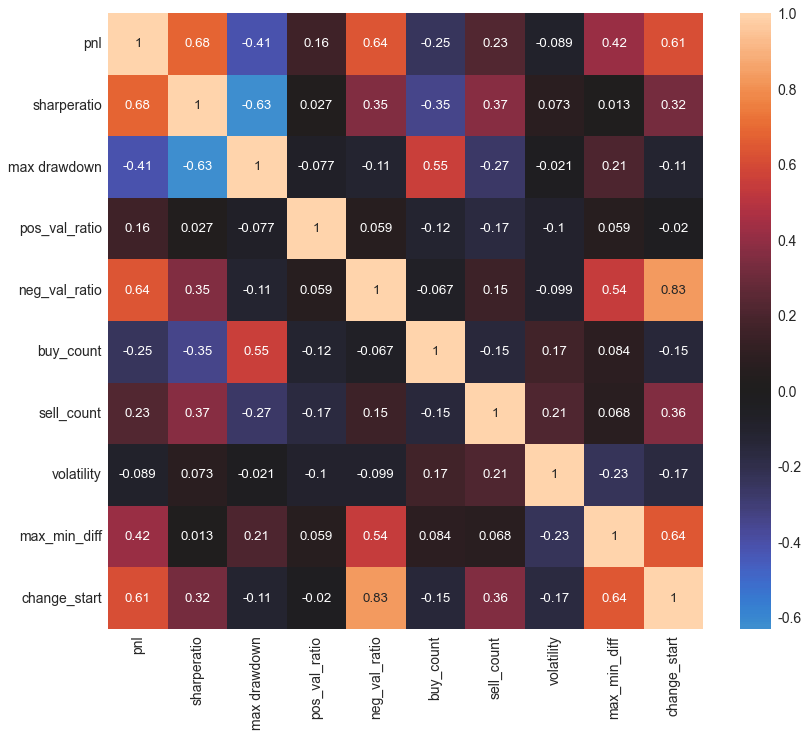

In [41]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    df.corr(),
    xticklabels=df.corr().columns,
    yticklabels=df.corr().columns,
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
    },
)
plt.show()


In [ ]:
scipy.stats.pearsonr(max_min_lst, pnl_lst)

PearsonRResult(statistic=0.4132079031257236, pvalue=0.023233965947492226)

In [138]:
data = pd.DataFrame({'X': dataframe['neg_conf'],
                     'Y': dataframe['S_DQ_VOLUME']})
data.corr(method='spearman')

,X,Y
X,1.000000,-0.156445
Y,-0.156445,1.000000


In [ ]:
print(round(np.std(pnl_lst), 2), round(np.mean(pnl_lst), 2), np.mean())

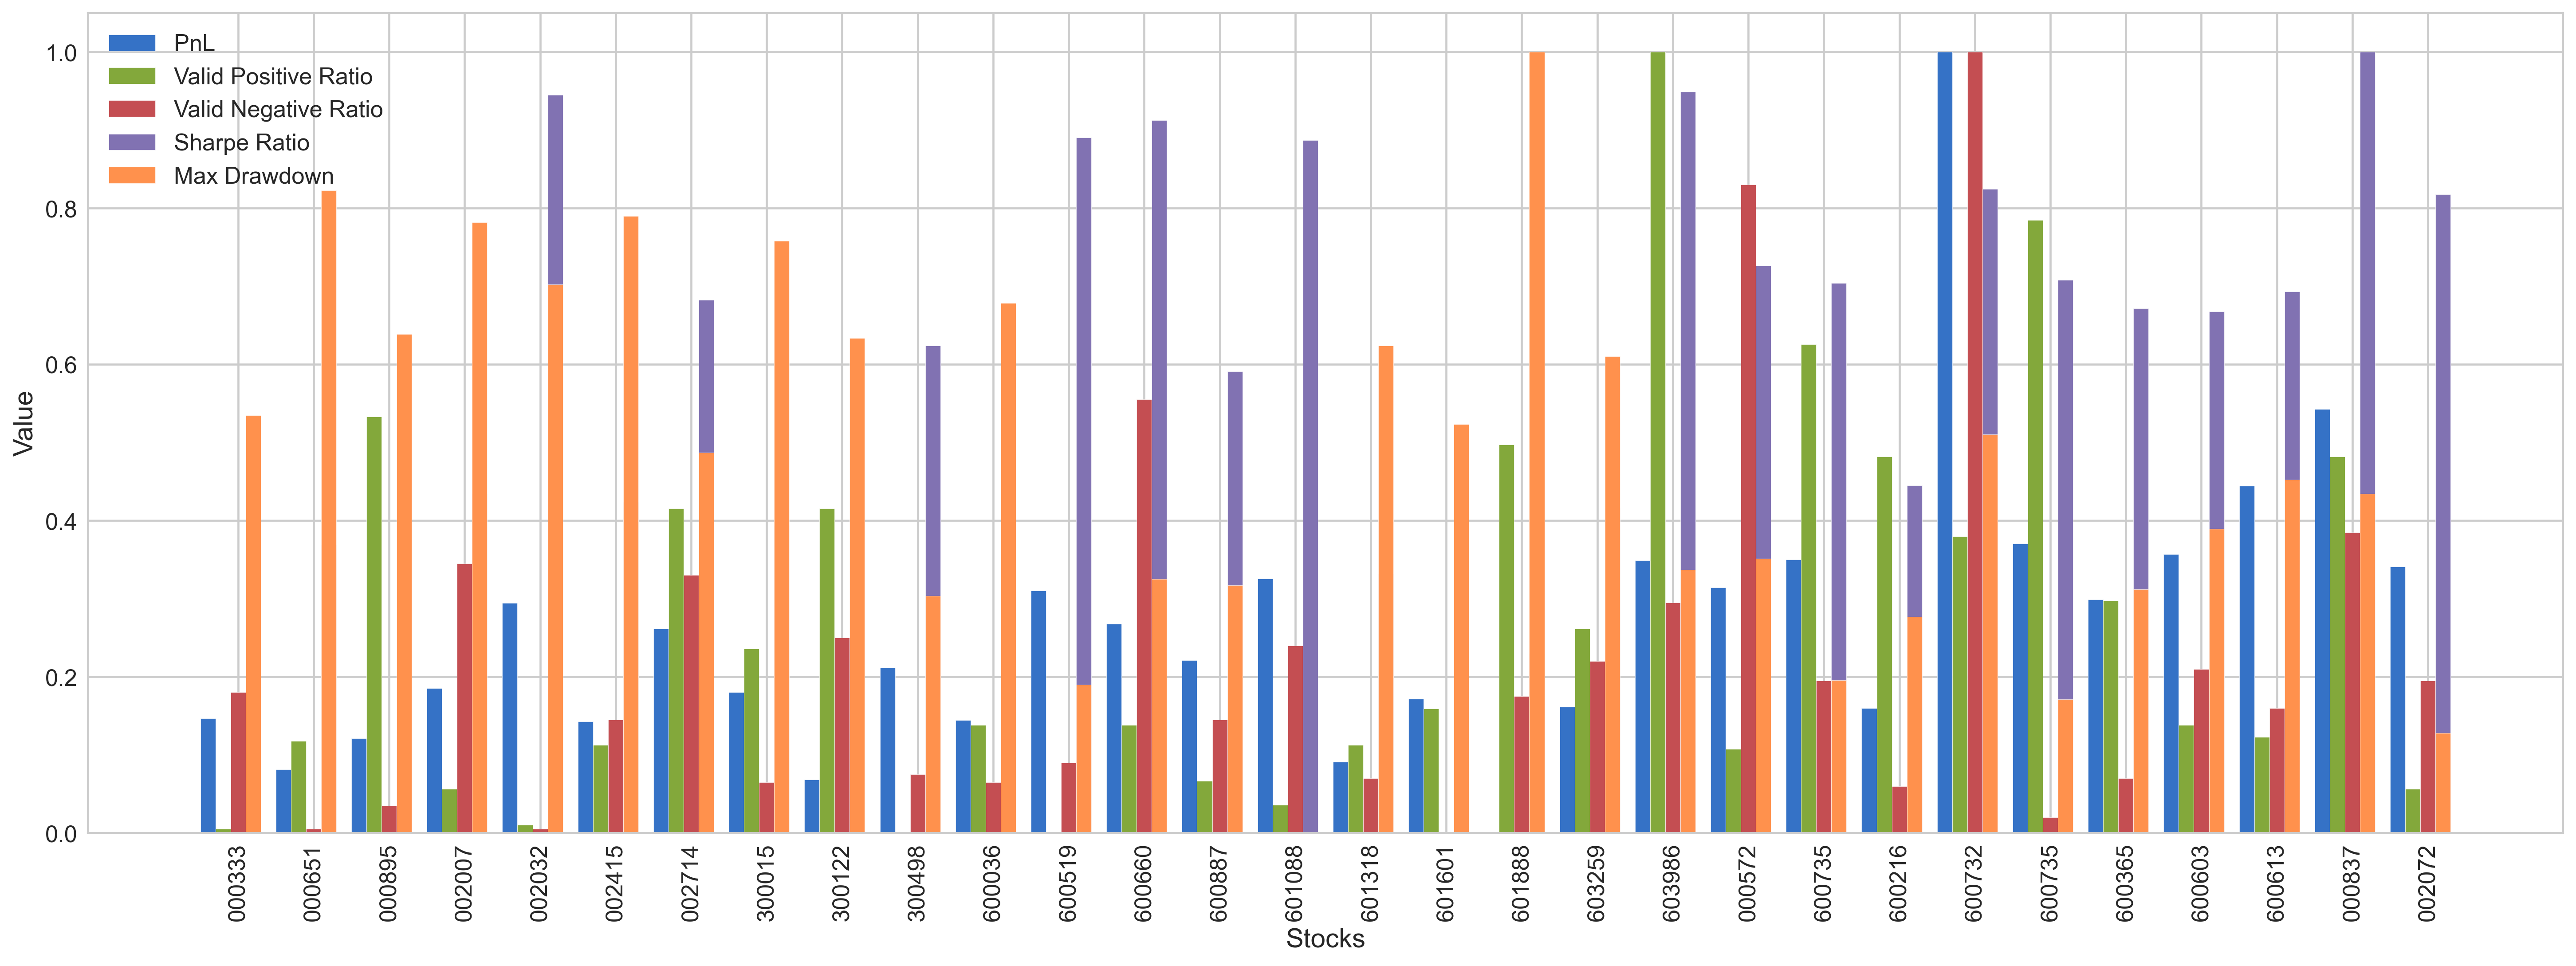

In [46]:
# Set the width of the bars
bar_width = 0.2
plt.figure(dpi=300,figsize=(24,8))

# Set the positions of the bars on the x-axis
r1 = range(len(stocks))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

pnl = np.array(pnl_lst)
max_drawdown = np.array(max_drawdown_lst)
sharperatio = np.array(sharperatio_lst)
# Plot the bars
plt.bar(r1, (pnl-np.min(pnl))/(np.max(pnl)-np.min(pnl)), width=bar_width, label='PnL')
plt.bar(r2, (pos_val_ratio_lst-np.min(pos_val_ratio_lst))/(np.max(pos_val_ratio_lst)-np.min(pos_val_ratio_lst)), width=bar_width, label='Valid Positive Ratio')
plt.bar(r3, (neg_val_ratio_lst-np.min(neg_val_ratio_lst))/(np.max(neg_val_ratio_lst)-np.min(neg_val_ratio_lst)), width=bar_width, label='Valid Negative Ratio')
plt.bar(r4, (sharperatio-np.min(sharperatio))/(np.max(sharperatio)-np.min(sharperatio)), width=bar_width, label='Sharpe Ratio')
plt.bar(r4, (max_drawdown-np.min(max_drawdown))/(np.max(max_drawdown)-np.min(max_drawdown)), width=bar_width, label='Max Drawdown')

#plt.bar(r1, pnl, width=bar_width, label='PnL')

# Add x-axis labels and tick labels
plt.xlabel('Stocks')
plt.xticks([r + bar_width * 2 for r in range(len(stocks))], stocks, rotation=90)

# Add y-axis label
plt.ylabel('Value')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
np.std(max_drawdown_lst)

9.857419095393187

In [ ]:
np.mean(max_drawdown_lst)

22.992333333333338

In [ ]:
# 账户自选
'600030', '601318', '000002', '600036', '600000', '301026'

In [ ]:
# 2021-09-30
high_vol_stocks = ['301069', '301060', '688622', '000670', '301052', '000792', '301055']
low_vol_stocks = ['601169', '601288', '601229', '601398']


In [20]:
print(np.mean(pnl_lst), np.mean(sharperatio))

NameError: name 'sharperatio' is not defined

In [ ]:
print(np.mean(pos_val_ratio_lst), np.mean(neg_val_ratio_lst))

0.5746666666666667 0.507


In [ ]:
df=ts.get_k_data('000023',autype='qfq',start='2020-07-05',end='2023-07-05')

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


C:\Users\zhanq\AppData\Roaming\Python\Python39\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
C:\Users\zhanq\AppData\Roaming\Python\Python39\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


In [ ]:
dataframe=get_data('600732')
time = [pd.Timestamp.toordinal(dt.strptime(str(t1), '%Y-%m-%d %H:%M:%S')) for t1 in dataframe.index]
price = np.log(dataframe['close'].values)
observations = np.array([time, price])

lppls_model = lppls.LPPLS(observations=observations)
res = lppls_model.mp_compute_nested_fits(
        workers=12,
        window_size=120,
        smallest_window_size=5,
        outer_increment=5,
        inner_increment=2,
        max_searches=25,
)
res_df = lppls_model.compute_indicators(res)
pos_val_ratio = val_indicator_ratio(res_df, 'pos_conf')
neg_val_ratio = val_indicator_ratio(res_df, 'neg_conf')
print(pos_val_ratio, neg_val_ratio)

In [ ]:
print(np.std(pnl_lst), np.mean(pnl_lst), np.max(pnl_lst), np.min(pnl_lst))

39252.675379750304 9247.772696002194 176359.8533640891 -35201.740776723425


#### 稳定性分析
##### 随机选取多只股票回测取平均

In [ ]:
print(round(np.min(pnl_lst)/100000*100/3, 2),'%')

-12.37 %
